In [1]:
import numpy as np

In [2]:
dataset_path = r"C:\Users\Shant\OneDrive\Documents\My Folder\Dataset\Sea_Images"

# Data Preprocessing:

In [3]:
import tensorflow as tf

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
SEED = 42

dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    labels='inferred',
    label_mode='int',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

print("Images loaded and resized successfully.")

c:\Users\Shant\OneDrive\Desktop\Data_Science\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Found 13716 files belonging to 23 classes.
Images loaded and resized successfully.


## Apply Data Augmentation


In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

augmented_dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

print("Data augmentation layers defined and applied to the dataset.")

Data augmentation layers defined and applied to the dataset.


## Normalize Pixel Values

In [5]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

normalized_dataset = augmented_dataset.map(normalize_img)

print("Pixel values normalized to [0, 1] range.")

Pixel values normalized to [0, 1] range.


## Apply Image Enhancement

In [6]:
def apply_enhancement(image, label):
    image = tf.image.adjust_contrast(image, contrast_factor=1.2)
    return image, label

enhanced_dataset = normalized_dataset.map(apply_enhancement)

print("Image enhancement (contrast adjustment) applied to the dataset.")

Image enhancement (contrast adjustment) applied to the dataset.


# Model Selection & Transfer Learning:

In [7]:
from tensorflow.keras.applications import VGG16

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

print("VGG16 base model loaded with ImageNet weights.")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step
VGG16 base model loaded with ImageNet weights.


In [8]:
base_model.trainable = False

print("VGG16 base model layers frozen.")

VGG16 base model layers frozen.


## Add and Modify Top Layers for Classification


In [9]:
from tensorflow.keras import layers, models

x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
num_classes = len(dataset.class_names)
predictions = layers.Dense(num_classes, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=predictions)

print("New classification layers added and combined with the base model.")

New classification layers added and combined with the base model.


In [10]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

print("Model compiled successfully.")

Model compiled successfully.


# Hyperparameter Tuning:


In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Early Stopping callback defined.")

Early Stopping callback defined.


In [12]:
initial_learning_rate = 0.1
epochs = 20

print(f"Initial Learning Rate: {initial_learning_rate}")
print(f"Epochs: {epochs}")

Initial Learning Rate: 0.1
Epochs: 20


# Model Training:

In [13]:
val_split = 0.2
dataset_size = tf.data.experimental.cardinality(enhanced_dataset).numpy()
val_size = int(dataset_size * val_split)

train_dataset = enhanced_dataset.skip(val_size)
val_dataset = enhanced_dataset.take(val_size)

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

print(f"Training dataset size: {tf.data.experimental.cardinality(train_dataset).numpy()} batches")
print(f"Validation dataset size: {tf.data.experimental.cardinality(val_dataset).numpy()} batches")
print("Data split into training and validation sets, and optimized for performance.")

Training dataset size: 344 batches
Validation dataset size: 85 batches
Data split into training and validation sets, and optimized for performance.


In [14]:
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=[early_stopping]
)

print("Model training complete.")

Epoch 1/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 365s 1s/step - accuracy: 0.2471 - loss: 2.5446 - val_accuracy: 0.4033 - val_loss: 2.0221
Epoch 2/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 338s 983ms/step - accuracy: 0.3630 - loss: 2.0964 - val_accuracy: 0.4324 - val_loss: 1.8717
Epoch 3/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 326s 947ms/step - accuracy: 0.4105 - loss: 1.9034 - val_accuracy: 0.4563 - val_loss: 1.8329
Epoch 4/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 322s 937ms/step - accuracy: 0.4473 - loss: 1.7810 - val_accuracy: 0.4706 - val_loss: 1.7538
Epoch 5/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 331s 962ms/step - accuracy: 0.4697 - loss: 1.6811 - val_accuracy: 0.4599 - val_loss: 1.8226
Epoch 6/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.4920 - loss: 1.6087 - val_accuracy: 0.4809 - val_loss: 1.7846
Epoch 7/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 322s 935ms/step - accuracy: 0.5009 - loss: 1.5550 - val_accuracy: 0.4779 - val_loss: 1.8085
Epoch 8/20
344/344 ━━━━━━━━━━━━━━━━━━━━ 319s 927ms/step - accuracy: 0.5298 - loss:

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,51

 Total params: 21,164,039 (80.73 MB)

 Trainable params: 2,149,783 (8.20 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 4,299,568 (16.40 MB)

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

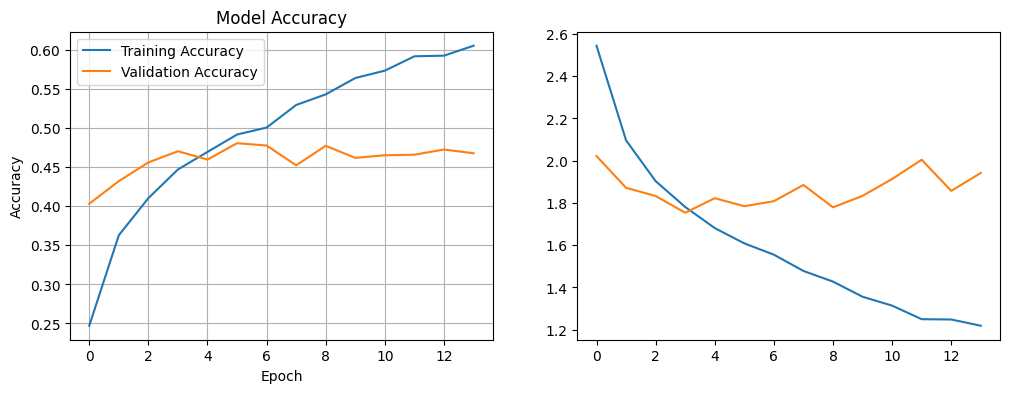

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')




--- Classification Report ---

              precision    recall  f1-score   support

           0       0.38      0.18      0.25       109
           1       0.26      0.67      0.38        99
           2       0.68      0.56      0.62       103
           3       0.46      0.62      0.53       146
           4       0.27      0.10      0.15        97
           5       0.24      0.24      0.24        98
           6       0.81      0.73      0.77       190
           7       0.36      0.36      0.36        77
           8       0.26      0.30      0.28        96
           9       0.15      0.09      0.11       109
          10       0.84      0.82      0.83        99
          11       0.34      0.62      0.44        93
          12       0.35      0.18      0.24       104
          13       0.28      0.20      0.23       111
          14       0.83      0.84      0.84       106
          15       0.34      0.23      0.27        88
          16       0.48      0.38      0.42      

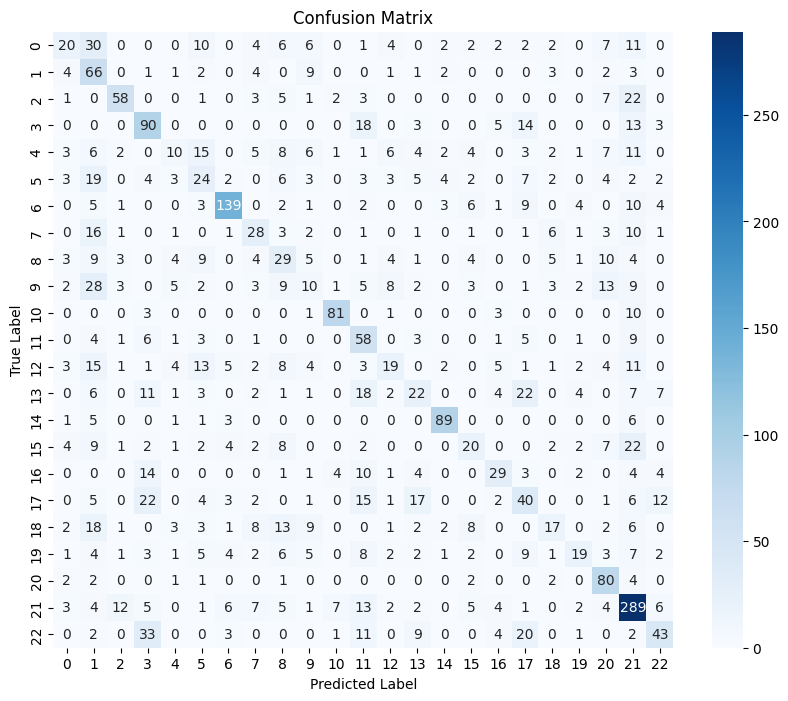

In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Gather predictions and true labels
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images, verbose=0))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)

# Class names
class_names = val_dataset.class_names if hasattr(val_dataset, 'class_names') else [str(i) for i in range(len(np.unique(y_true)))]

# 2. Classification report
print("\n--- Classification Report ---\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


y_pred_probs shape: (2720, 23)


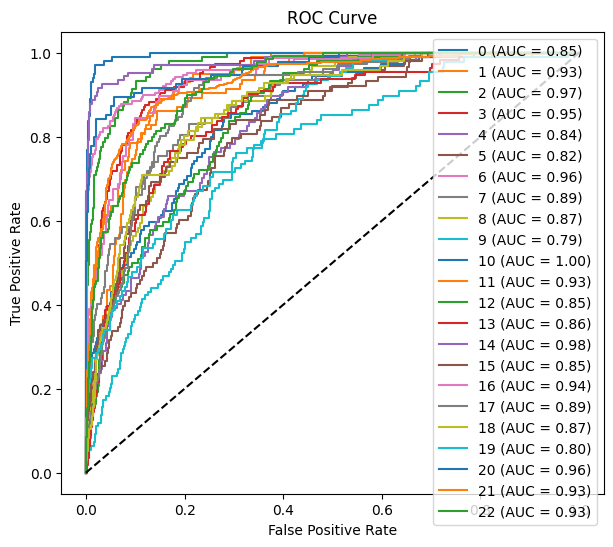

In [19]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 1. Collect predictions and true labels from test_dataset
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    y_true.extend(labels.numpy())
    # model.predict returns an array of shape (batch_size, num_classes)
    y_pred_probs.extend(model.predict(images, verbose=0))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)  # shape: (num_samples, num_classes)

# Check shape
print("y_pred_probs shape:", y_pred_probs.shape)  # should be (num_samples, num_classes)

# 2. Binarize true labels for one-vs-rest ROC
lb = LabelBinarizer()
y_true_bin = lb.fit_transform(y_true)

# If your problem has 2 classes, LabelBinarizer returns a single column; force 2 columns
if y_true_bin.shape[1] == 1:
    y_true_bin = np.hstack((1 - y_true_bin, y_true_bin))

num_classes = y_true_bin.shape[1]

# 3. Class names
class_labels = val_dataset.class_names if hasattr(val_dataset, 'class_names') else [str(i) for i in range(num_classes)]

# 4. Plot ROC curves
plt.figure(figsize=(7,6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_labels[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [ ]:
model.save("sea_images_vgg16_model.keras")

print("Model saved successfully as 'sea_images_vgg16_model.keras'.")